# 🩺 Insurance Cost Data Analysis & Reporting

This notebook mirrors the structure used in the automobile analysis, covering data preparation, feature engineering, outlier control, and focused correlation analysis for medical insurance charges.

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the insurance data
path = '/media/akashs/FA22E72622E6E69B/DATA1_disk/ACADEMICS/3_IPCS_Works/'
df = pd.read_csv(path+'./data/insurance.csv')
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 🧹 Data Cleaning & Preparation

In [2]:

# Encode categorical variables
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df = pd.get_dummies(df, columns=['region'], drop_first=True)

# Check for missing values
df.isnull().sum()


age                 0
sex                 0
bmi                 0
children            0
smoker              0
charges             0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

## 🛠️ Feature Engineering

In [3]:

# Feature: BMI category
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100],
                            labels=['underweight', 'normal', 'overweight', 'obese'])

# Feature: Interaction term
df['bmi_smoker'] = df['bmi'] * df['smoker']


In [4]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'region_northwest', 'region_southeast', 'region_southwest',
       'bmi_category', 'bmi_smoker'],
      dtype='object')

## 📊 Outlier Visualization (Boxplots)

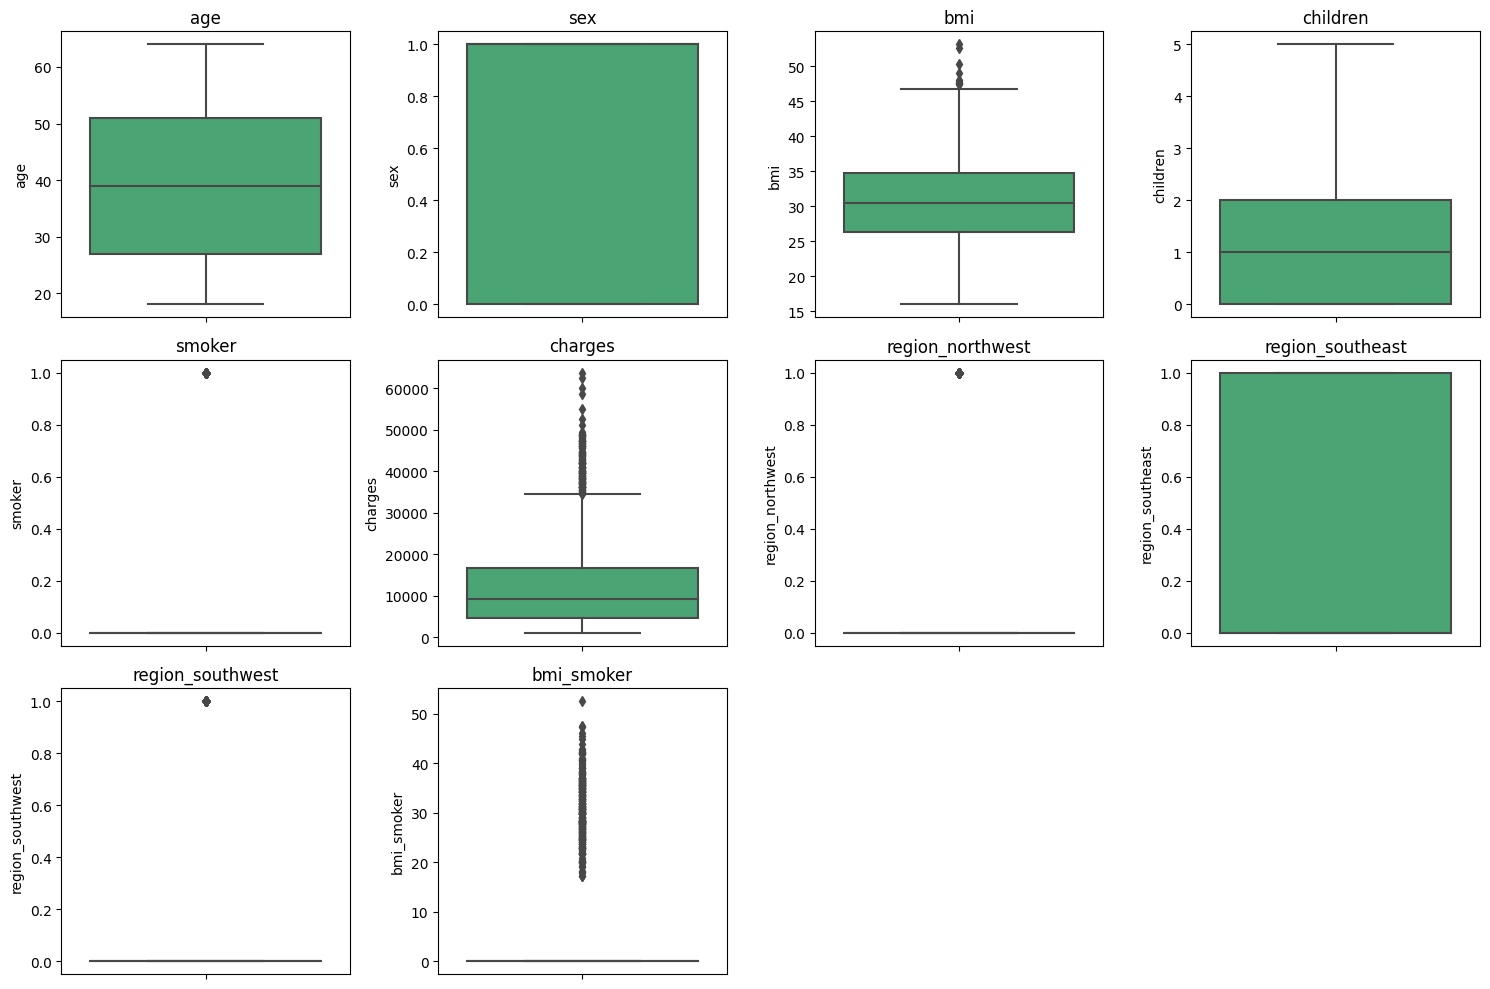

In [5]:

fig = plt.figure(figsize=(15, 10))
numeric_cols = df.select_dtypes(include='number').columns
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=col, data=df, color='#3CB371')
    plt.title(col)
plt.tight_layout()
plt.show()


## 🔍 Outlier Handling with Winsorization

In [6]:

from scipy import stats

# Outlier removal using Z-score method on selected numerical columns
numeric_cols = ['age', 'bmi', 'children', 'charges']

# Z-Score
# # df = df[(np.abs(stats.zscore(df.select_dtypes(include=['number']).columns)) < 3).all(axis=1)]
# df = df[(np.abs(stats.zscore(df.select_dtypes(include=['number']))) < 3).all(axis=1)]

# Winsorization (or capping)
# df[df.select_dtypes(include='number').columns] = df.select_dtypes(include='number').apply(lambda x: x.clip(lower=x.quantile(0.25), upper=x.quantile(0.75)))
# df[numeric_cols] = df[numeric_cols].apply(lambda x: x.clip(lower=x.quantile(0.25), upper=x.quantile(0.75)))

for column in numeric_cols:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    Maximum = Q3 + 1.5 * IQR
    Minimum = Q1 - 1.5 * IQR
    df[column] = df[column].clip(lower=Minimum, upper=Maximum)


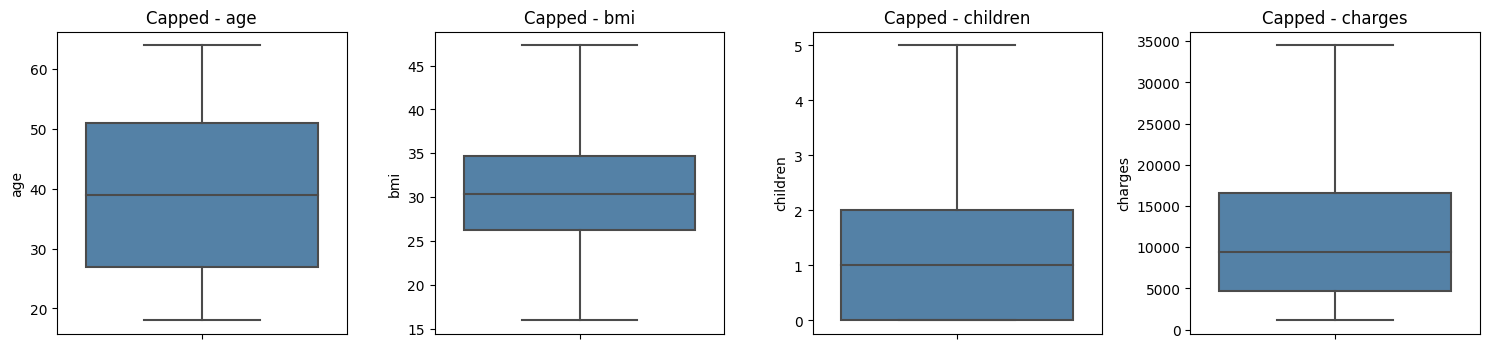

In [7]:

fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=col, data=df, color='#4682B4')
    plt.title(f"Capped - {col}")
plt.tight_layout()
plt.show()


## 📊 Initial Correlation Heatmap

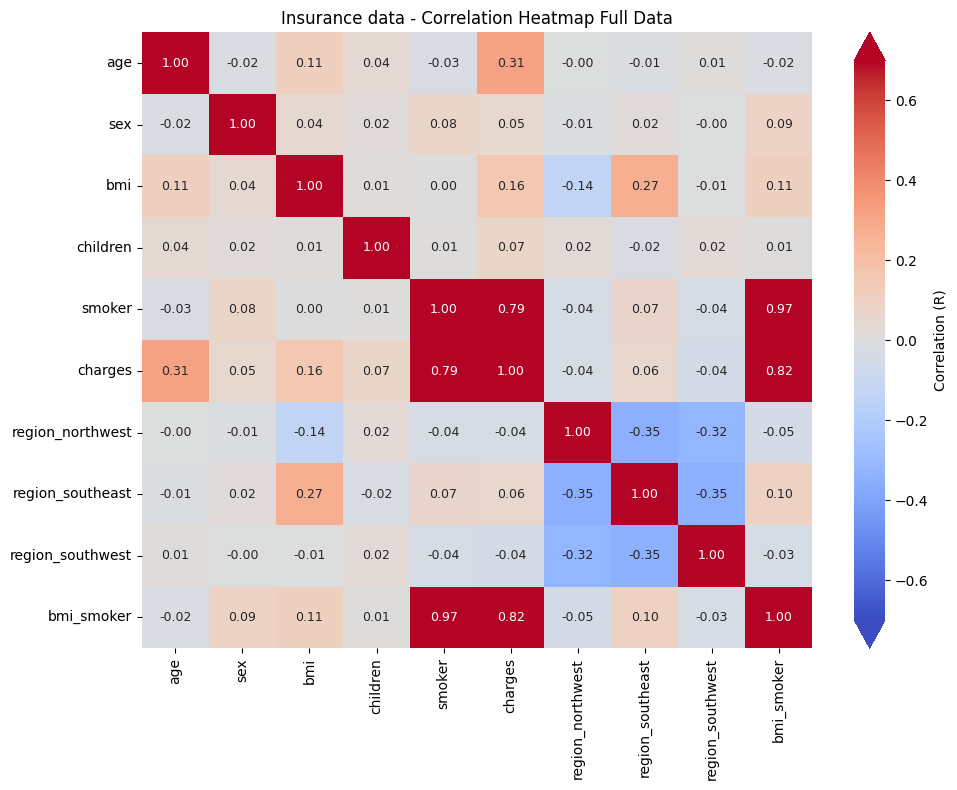

In [8]:

# plt.figure(figsize=(10, 8))
# sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', vmin=-0.7, vmax=0.7, extend='both')
# plt.title("Correlation Heatmap")
# plt.show()


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap without the colorbar
norm = plt.Normalize(vmin=-0.7, vmax=0.7)
cmap = plt.get_cmap('coolwarm')

heatmap = sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    norm=norm,
    cbar=False,  # we will add it manually
    ax=ax,
    annot_kws={"size": 9},
)

# Manually add a colorbar with extend arrows
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, extend='both')
cbar.set_label('Correlation (R)')

# 🔧 Remove black border around the colorbar
for spine in cbar.ax.spines.values():
    spine.set_visible(False)
    
plt.title('Insurance data - Correlation Heatmap Full Data')
# plt.savefig('./plots/insurance_correlation_heatmap_full_data.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



## 🎯 Focused Correlation Heatmap (Highly Correlated Features Only)

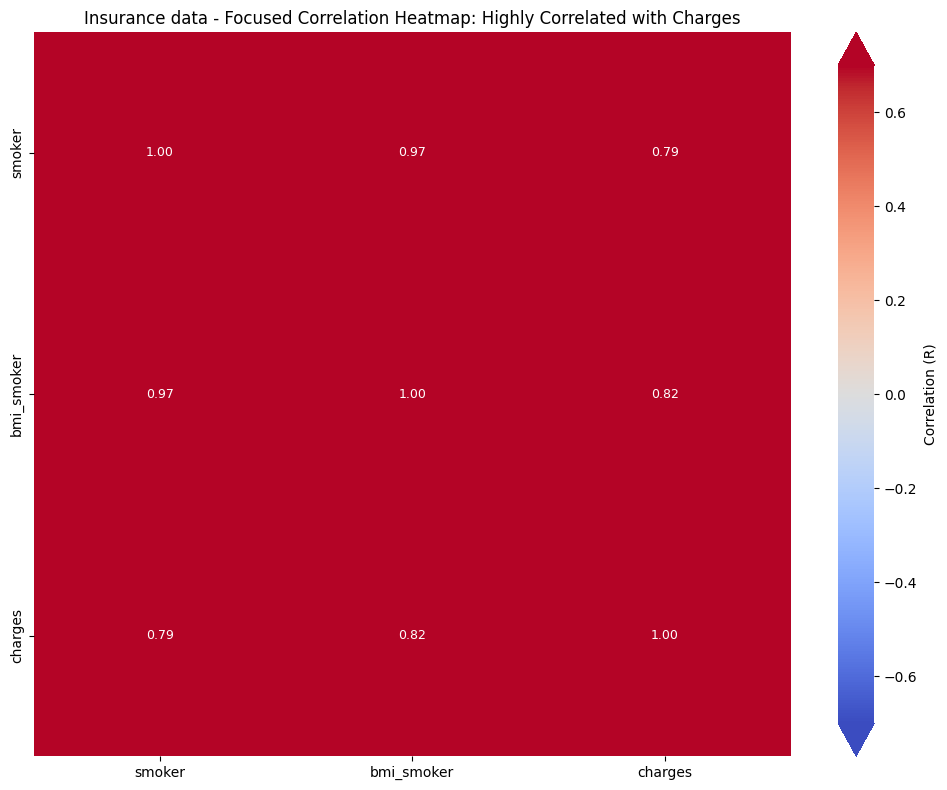

In [9]:

# Find highly correlated features with price using manual correlation filtering
high_corr_colms = []
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'charges':
        corr = df['charges'].corr(df[col])
        if corr > 0.4 or corr < -0.4:
            high_corr_colms.append(col)
high_corr_colms.append('charges')  # include target variable

# # Plot heatmap for selected features
# plt.figure(figsize=(10, 7))
# sns.heatmap(df[high_corr_colms].corr(), annot=True, cmap='YlOrRd')
# plt.title("Focused Correlation Heatmap: Highly Correlated with Price")
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap without the colorbar
norm = plt.Normalize(vmin=-0.7, vmax=0.7)
cmap = plt.get_cmap('coolwarm')

heatmap = sns.heatmap(
    df[high_corr_colms].corr(numeric_only=True),
    annot=True,
    fmt='.2f',
    cmap=cmap,
    norm=norm,
    cbar=False,  # we will add it manually
    ax=ax,
    annot_kws={"size": 9},
)

# Manually add a colorbar with extend arrows
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, extend='both')
cbar.set_label('Correlation (R)')

# 🔧 Remove black border around the colorbar
for spine in cbar.ax.spines.values():
    spine.set_visible(False)
    
plt.title('Insurance data - Focused Correlation Heatmap: Highly Correlated with Charges')
# plt.savefig('./plots/insurance_correlation_heatmap_high_corrs.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 🔁 Refined Correlation Heatmap with Engineered Features

In [10]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'region_northwest', 'region_southeast', 'region_southwest',
       'bmi_category', 'bmi_smoker'],
      dtype='object')

/tmp/ipykernel_14568/1839358773.py:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[selected_cols].corr(),


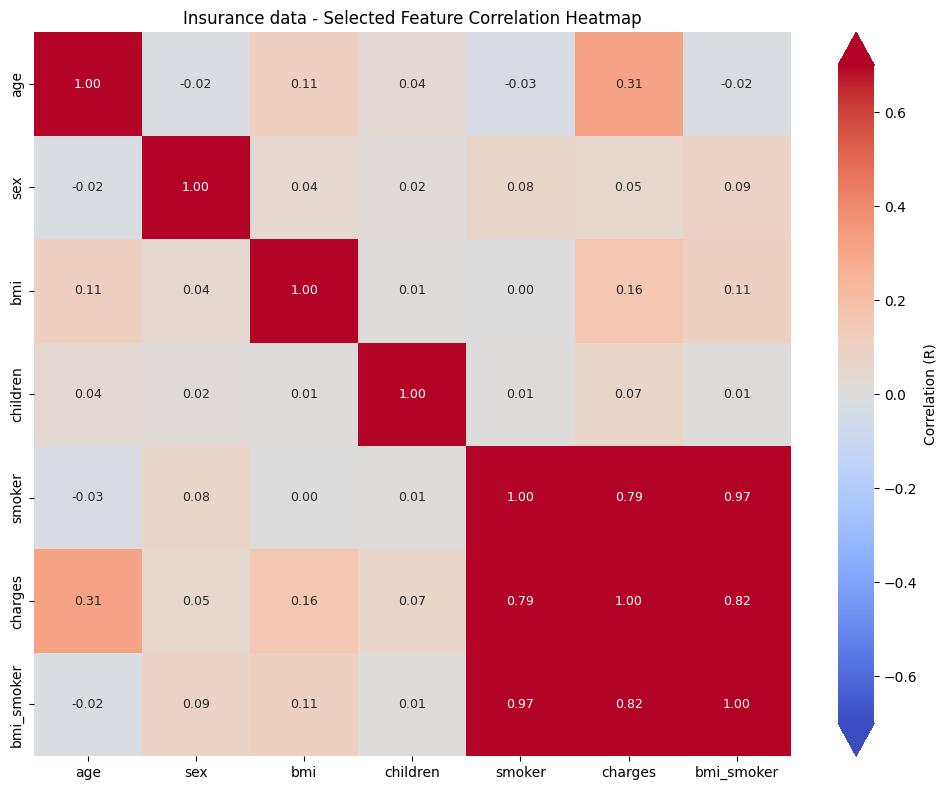

In [11]:

selected_cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'charges',\
                 'bmi_category', 'bmi_smoker']


# plt.figure(figsize=(10, 7))
# sns.heatmap(df[selected_cols].corr(), annot=True, fmt='.2f', cmap='YlGnBu')
# plt.title("Selected Feature Correlation Heatmap")
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap without the colorbar
norm = plt.Normalize(vmin=-0.7, vmax=0.7)
cmap = plt.get_cmap('coolwarm')

heatmap = sns.heatmap(
    df[selected_cols].corr(),
    annot=True,
    fmt='.2f',
    cmap=cmap,
    norm=norm,
    cbar=False,  # we will add it manually
    ax=ax,
    annot_kws={"size": 9},
)

# Manually add a colorbar with extend arrows
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, extend='both')
cbar.set_label('Correlation (R)')

# 🔧 Remove black border around the colorbar
for spine in cbar.ax.spines.values():
    spine.set_visible(False)
    
plt.title('Insurance data - Selected Feature Correlation Heatmap')
# plt.savefig('./plots/insurance_correlation_heatmap_selected.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [12]:
data = df[['age', 'bmi', 'smoker', 'charges']] # high correlation columns
data
 	 	 	 	 	 	

,age,bmi,smoker,charges
0,19,27.900,1,16884.92400
1,18,33.770,0,1725.55230
2,28,33.000,0,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,0,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [13]:
data.isnull().sum()

age        0
bmi        0
smoker     0
charges    0
dtype: int64

# Target Encoder

In [14]:
# # !pip install category_encoders
# import category_encoders as ce

# # Initialize TargetEncoder
# TarEnc = ce.TargetEncoder()

# # Fit and Transform
# for col in categorical_cols:
#     data[col] = TarEnc.fit_transform(data[col], data['price'])


import category_encoders as ce

# Ensure 'categorical_cols' only contains the categorical column names
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Initialize and fit the encoder
TarEnc = ce.TargetEncoder(cols=categorical_cols)
data[categorical_cols] = TarEnc.fit_transform(data[categorical_cols], data['charges'])


# Selecting Predictors and Target columns

In [15]:
x = data.drop('charges', axis=1)  # Features/Predictors
y = data['charges'] # Target/Label

# Splitting data to train and test (test size=20%, train size=80%)

In [16]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test= train_test_split(x,y,random_state=44,test_size=0.2)


#### Taking a copy of raw train and test x, y splits before scaling for cross-validation and refit model after cross-validation

In [17]:
# Copy raw train data
x_train_raw = x_train.copy()
y_train_raw = y_train.copy()

# Copy raw test data
x_test_raw = x_test.copy()
y_test_raw = y_test.copy()


In [18]:
print(x_train.shape) 
print(x_test.shape) 
print(y_train.shape) 
print(y_test.shape)

(1070, 3)
(268, 3)
(1070,)
(268,)


In [19]:
x_train.head(3)

,age,bmi,smoker
708,31,30.495,0
1252,20,27.300,1
916,43,26.885,1


In [20]:
x_test.head(3)

,age,bmi,smoker
440,31,32.68,0
1202,22,32.11,0
820,45,33.70,0


In [21]:
# x_train.iloc[:, 1:3]

# Using StandardScalar

In [22]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

x_train.iloc[:, 0:2] = scalar.fit_transform(x_train.iloc[:, 0:2])
x_test.iloc[:, 0:2] = scalar.transform(x_test.iloc[:, 0:2])

In [23]:
x_train.head(3)

,age,bmi,smoker
708,-0.583113,-0.038760,0
1252,-1.359585,-0.577120,1
916,0.263948,-0.647048,1


In [24]:
x_test.head(3)

,age,bmi,smoker
440,-0.583113,0.329414,0
1202,-1.218408,0.233369,0
820,0.405124,0.501285,0


In [25]:
y_test.head(3)

440     4738.2682
1202    2055.3249
820     7445.9180
Name: charges, dtype: float64

In [26]:
x_train.shape

(1070, 3)

In [27]:
y_train.isnull().sum()

0

# Hyperparameter tuning

In [28]:
# hyperparameter tuning using GridSearchCV — the process of finding the best model settings (like the best k in KNN) using cross-validation.
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score # KFold - regression data
# from sklearn.model_selection import StratifiedKFold, cross_val_score # StratifiedKFold - classification data
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

#### Specify which hyperparameters you want to tune for each model.

In [29]:
# KNN Hyperparameter Grid
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # double underscore required e.g: knn__
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2] # 1 = Manhattan, 2 = Euclidean
}

# Linear Regression (No hyperparameters to tune)
linear_param_grid = {}

# # Logistic Regression Hyperparameter Grid (if classification)
# logistic_param_grid = {
#     'logistic__C': [0.01, 0.1, 1, 10, 100], # Regularization strength
#     'logistic__solver': ['lbfgs', 'liblinear']
# }

# Decision Tree Hyperparameter Grid
decision_tree_param_grid = {
    'dt__max_depth': [None, 10, 20, 30, 50],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 5]
}

# Random Forest Hyperparameter Grid
random_forest_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5]
}

Tuning KNN...
Best Hyperparameters for KNN: {'knn__n_neighbors': 9, 'knn__p': 2, 'knn__weights': 'uniform'}
Best Cross-validation R² Score for KNN: 0.7944510980401478

Tuning Linear Regression...
Best Hyperparameters for Linear Regression: {}
Best Cross-validation R² Score for Linear Regression: 0.738259148706603

Tuning Decision Tree...
Best Hyperparameters for Decision Tree: {'dt__max_depth': 10, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 2}
Best Cross-validation R² Score for Decision Tree: 0.7671171950291604

Tuning Random Forest...
Best Hyperparameters for Random Forest: {'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best Cross-validation R² Score for Random Forest: 0.7941291706517671

Final Train Score for KNN: 0.8332709520991132
Final Train Score for Linear Regression: 0.7426915090392627
Final Train Score for Decision Tree: 0.8638375885295935
Final Train Score for Random Forest: 0.8629285923212444
Final Test R² Score

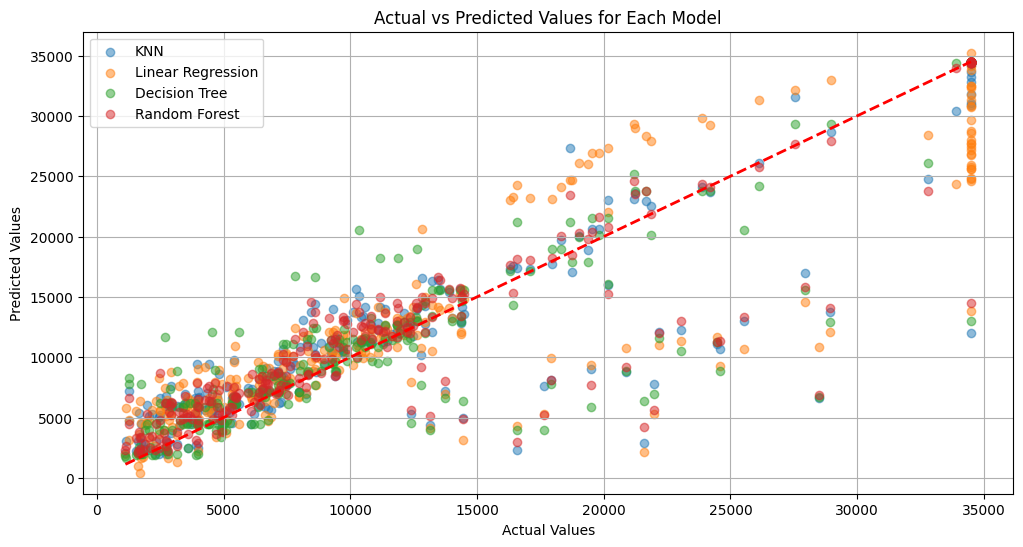

CPU times: user 3.38 s, sys: 469 ms, total: 3.85 s
Wall time: 1min 50s


In [30]:
%%time

# Pipelines for models
knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])
linear_pipeline = Pipeline([('scaler', StandardScaler()), ('linear', LinearRegression())])
# logistic_pipeline = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(max_iter=1000))])
decision_tree_pipeline = Pipeline([('dt', DecisionTreeRegressor())])
random_forest_pipeline = Pipeline([('rf', RandomForestRegressor(random_state=42))])


# Dictionary of machine learning models with their corresponding pipelines and hyperparameter grids
# Loop over multiple models for training, comparison, or tuning.
models = {
    "KNN": (knn_pipeline, knn_param_grid),
    "Linear Regression": (linear_pipeline, linear_param_grid),
    # "Logistic Regression": (logistic_pipeline, logistic_param_grid),
    "Decision Tree": (decision_tree_pipeline, decision_tree_param_grid),
    "Random Forest": (random_forest_pipeline, random_forest_param_grid)
}


# Dictionary to store the best models after hyperparameter tuning
best_models = {}

# Loop through each model and its associated pipeline and param grid
for name, (pipeline, param_grid) in models.items():
    print(f"Tuning {name}...")
    print("="*50)
    # Initialize GridSearchCV with pipeline, param grid, 5-fold CV, and R² scoring
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    
    # Fit GridSearchCV on training data
    grid_search.fit(x_train_raw, y_train_raw)

    # Store the best estimator (i.e., the pipeline with best hyperparameters) in the dictionary
    best_models[name] = grid_search.best_estimator_

    # Print the best hyperparameters found for this model
    print(f"Best Hyperparameters for {name}: {grid_search.best_params_}")
    # Print the best cross-validation R² score
    print(f"Best Cross-validation R² Score for {name}: {grid_search.best_score_}\n")


# Train all best models on full training data
for name, model in best_models.items():
    train_score = model.score(x_train_raw, y_train_raw)
    # model.fit(x_train_raw, y_train_raw)
    print(f"Final Train Score for {name}: {train_score}")

# Evaluate each model on the test set
for name, model in best_models.items():
    test_score = model.score(x_test_raw, y_test_raw)
    print(f"Final Test R² Score for {name}: {test_score}")

# Dictionary to store validation metrics
validation_results = {}
actual_vs_predicted = {}

for name, model in best_models.items():
    y_pred = model.predict(x_test_raw) # Predictions on test data
    
    # Compute validation metrics
    r2 = r2_score(y_test_raw, y_pred)
    mae = mean_absolute_error(y_test_raw, y_pred)
    mse = mean_squared_error(y_test_raw, y_pred)
    rmse = np.sqrt(mse) # Root Mean Squared Error
    
    validation_results[name] = {
        "R² Score": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

    # Store actual vs predicted values
    actual_vs_predicted[name] = pd.DataFrame({
        "Actual": y_test_raw.values,
        "Predicted": y_pred
    })

    # Print actual vs predicted
    print('------------------------------------------------------')
    print(f"\n{name} - Actual vs Predicted:\n")
    print(actual_vs_predicted[name].head())   

    # Print validation results
    print('------------------------------------------------------')
    print(f"Validation Metrics for {name}:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}\n")
   

# Convert validation results to DataFrame
metrics_df = pd.DataFrame(validation_results).T
print("\nValidation Metrics Summary:\n", metrics_df)
print(' ')

# # Save actual vs predicted values for each model
# for name, df in actual_vs_predicted.items():
#     df.to_csv(f"./data/{name}_actual_vs_predicted_housing.csv", index=False)
#     print(f'Validation results of {name} have been saved to ./data/{name}_actual_vs_predicted_housing.csv')
    
print(' ')

# Visualization: Scatter plot of Actual vs Predicted
plt.figure(figsize=(12, 6))

for name, df in actual_vs_predicted.items():
    plt.scatter(df["Actual"], df["Predicted"], label=name, alpha=0.5)

plt.plot([min(y_test_raw), max(y_test_raw)], [min(y_test_raw), max(y_test_raw)], 'r--', lw=2) # Perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Each Model")
plt.legend()
plt.grid()
plt.show()

# Addition exploration of actual and prediction & metrices

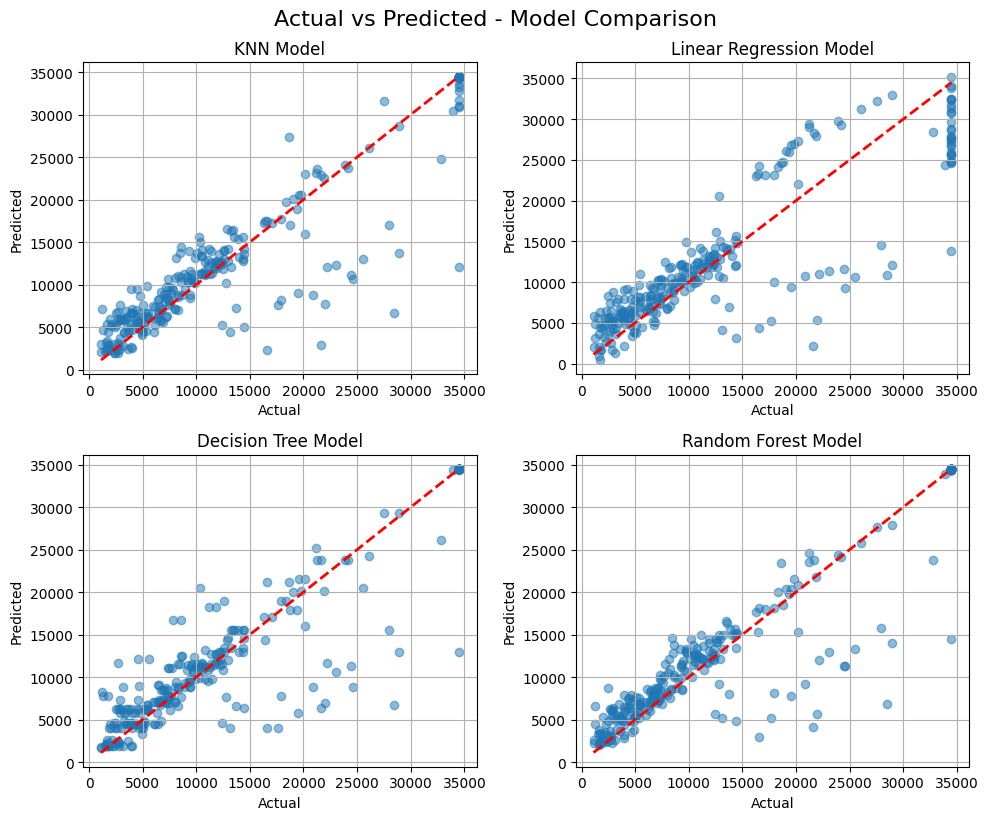

In [31]:
import math

# Number of models
n_models = len(actual_vs_predicted)

# Create subplot grid: square-ish layout
n_cols = math.ceil(math.sqrt(n_models))
n_rows = math.ceil(n_models / n_cols)

# Set figure size dynamically
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Plot each model's Actual vs. Predicted in a subplot
for i, (name, df) in enumerate(actual_vs_predicted.items(), start=1):
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(df["Actual"], df["Predicted"], alpha=0.5)
    plt.plot([min(y_test_raw), max(y_test_raw)], [min(y_test_raw), max(y_test_raw)], 'r--', lw=2)
    plt.title(f"{name} Model")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Actual vs Predicted - Model Comparison", fontsize=16, y=1.02)
plt.show()


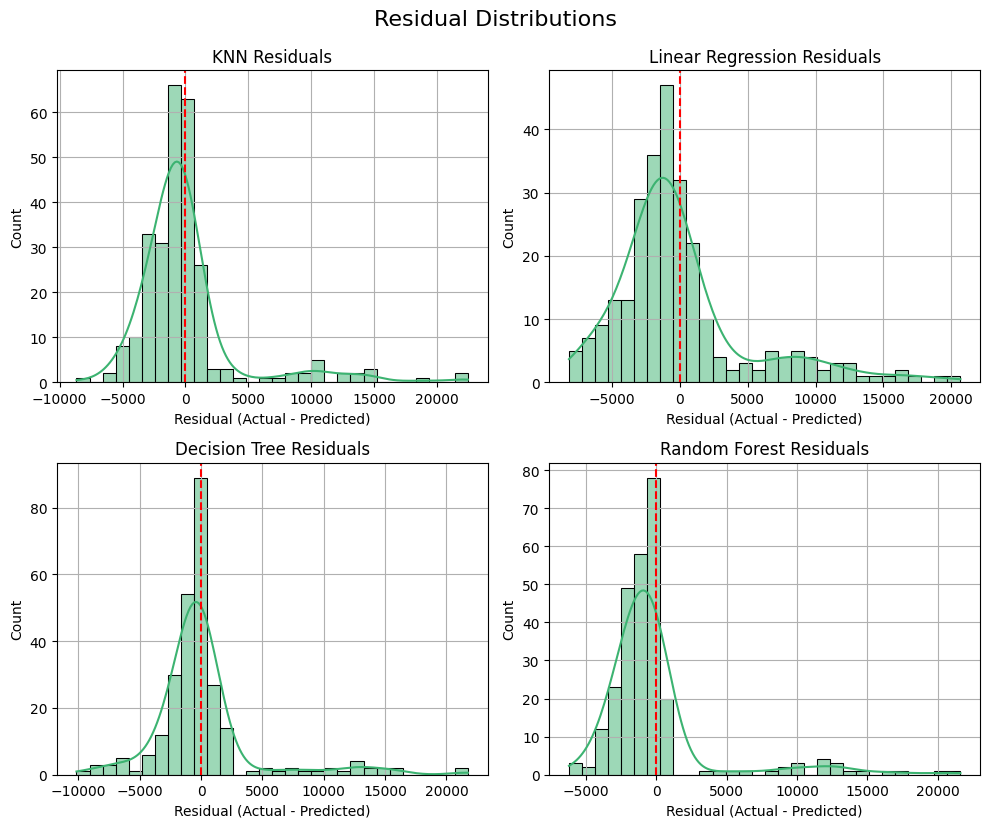

In [32]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

n_models = len(actual_vs_predicted)
n_cols = math.ceil(math.sqrt(n_models))
n_rows = math.ceil(n_models / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, (name, df) in enumerate(actual_vs_predicted.items(), start=1):
    residuals = df["Actual"] - df["Predicted"]
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(residuals, kde=True, bins=30, color='mediumseagreen')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"{name} Residuals")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Count")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Residual Distributions", fontsize=16, y=1.03)
plt.show()


In [33]:
from scipy.stats import skew
import numpy as np
import pandas as pd

residual_stats = []

# Step 1: Compute residual spread range across all models (for dynamic thresholding)
all_std = []
for model_name, df in actual_vs_predicted.items():
    residuals = df["Actual"] - df["Predicted"]
    all_std.append(residuals.std())

std_percentiles = np.percentile(all_std, [33, 66])

# Step 2: Analyze each model's residuals
for model_name, df in actual_vs_predicted.items():
    residuals = df["Actual"] - df["Predicted"]
    mean_resid = residuals.mean()
    std_resid = residuals.std()
    skew_resid = skew(residuals)
    
    # Symmetry
    symmetry_ratio = abs(mean_resid) / (std_resid + 1e-6)
    if symmetry_ratio < 0.2:
        symmetry = "Symmetric"
    elif skew_resid < -0.5:
        symmetry = "Left-skewed"
    elif skew_resid > 0.5:
        symmetry = "Right-skewed"
    else:
        symmetry = "Mild"

    # Spread (relative to global residual std distribution)
    if std_resid <= std_percentiles[0]:
        spread = "Tight"
    elif std_resid <= std_percentiles[1]:
        spread = "Moderate"
    else:
        spread = "Wide"

    # Bias
    if mean_resid < -0.3 * std_resid:
        bias = "Overpredict"
    elif mean_resid > 0.3 * std_resid:
        bias = "Underpredict"
    else:
        bias = "Minimal"

    # Notes
    if bias == "Minimal" and spread == "Tight" and symmetry == "Symmetric":
        note = "✅ Best performing"
    elif spread == "Wide" and symmetry != "Symmetric":
        note = "May overfit or unstable"
    elif bias != "Minimal":
        note = "Check for bias"
    else:
        note = "Stable model"

    residual_stats.append({
        "Model": model_name,
        "Symmetry": symmetry,
        "Spread": spread,
        "Bias": bias,
        "Notes": note
    })

# Step 3: Create and display the summary table
summary_df = pd.DataFrame(residual_stats)

print("\n🧠 Residual Summary Table:\n")
print(summary_df.to_markdown(index=False))



🧠 Residual Summary Table:

| Model             | Symmetry   | Spread   | Bias    | Notes              |
|:------------------|:-----------|:---------|:--------|:-------------------|
| KNN               | Symmetric  | Moderate | Minimal | Stable model       |
| Linear Regression | Symmetric  | Wide     | Minimal | Stable model       |
| Decision Tree     | Symmetric  | Wide     | Minimal | Stable model       |
| Random Forest     | Symmetric  | Tight    | Minimal | ✅ Best performing |


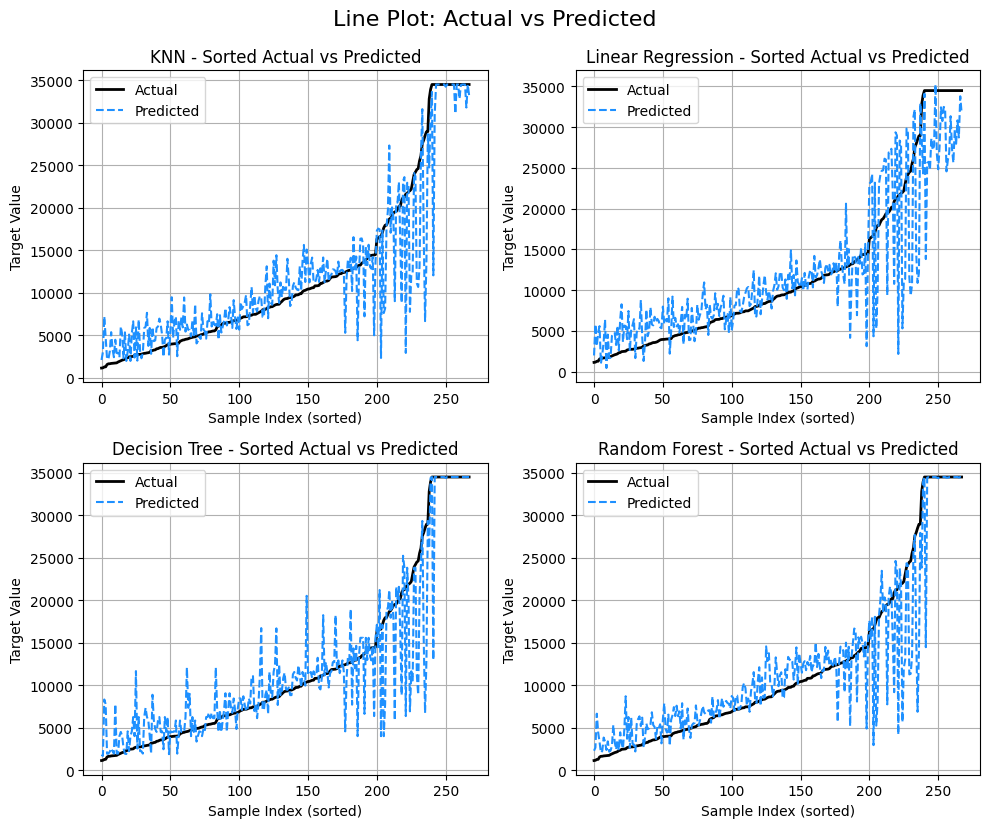

In [34]:
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, (name, df) in enumerate(actual_vs_predicted.items(), start=1):
    sorted_df = df.sort_values("Actual").reset_index(drop=True)
    
    plt.subplot(n_rows, n_cols, i)
    plt.plot(sorted_df["Actual"], label="Actual", linewidth=2, color='black')
    plt.plot(sorted_df["Predicted"], label="Predicted", linestyle='--', color='dodgerblue')
    plt.title(f"{name} - Sorted Actual vs Predicted")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Target Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Line Plot: Actual vs Predicted", fontsize=16, y=1.03)
plt.show()


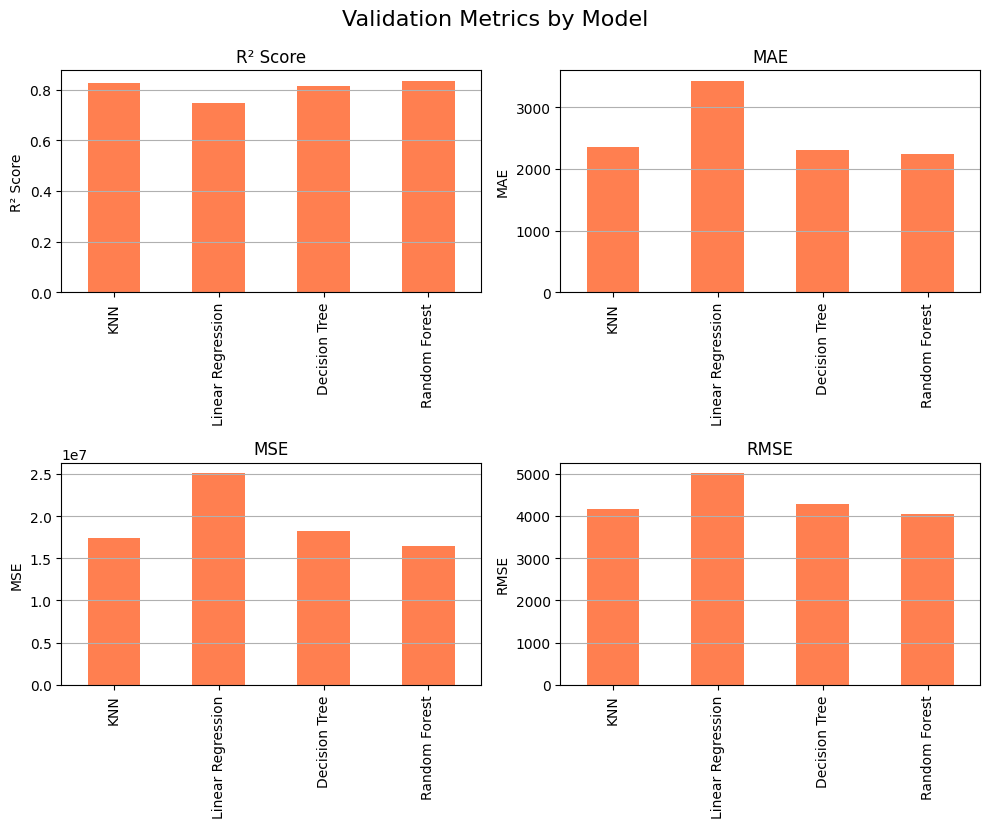

In [35]:
metric_names = metrics_df.columns.tolist()
n_metrics = len(metric_names)
n_cols = math.ceil(math.sqrt(n_metrics))
n_rows = math.ceil(n_metrics / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, metric in enumerate(metric_names, start=1):
    plt.subplot(n_rows, n_cols, i)
    metrics_df[metric].plot(kind='bar', color='coral')
    plt.title(metric)
    plt.ylabel(metric)
    plt.xticks(rotation=90)
    plt.grid(axis='y')

plt.tight_layout()
plt.suptitle("Validation Metrics by Model", fontsize=16, y=1.03)
plt.show()


# END OF CODE